# A first possibility for OGGM to have a mass balance model with daily input (precipitation and temperature) and daily output via `get_daily_mb` or  `get_specific_daily_mb`

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import massbalance, flowline

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, TIModel, BASENAMES, process_era5_daily_data
from MBsandbox.help_func import compute_stat, minimize_bias_geodetic, optimize_std_quot_brentq_geod

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = False

# this needs to be changed if working on another computer
working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

from oggm.utils import (floatyear_to_date, date_to_floatyear)


2023-04-11 12:22:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-11 12:22:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-11 12:22:37: oggm.cfg: Multiprocessing: using all available processors (N=8)


we use the Hintereisferner, but it should work for every glacier:

In [2]:
from MBsandbox.wip.projections_bayescalibration import process_isimip_data

In [21]:
# get HEF glacier>
df = ['RGI60-11.00897']
#df = ['RGI60-11.03208']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                          prepro_base_url=base_url,
                                          prepro_rgi_version='62')
gdir = gdirs[0]
h, w = gdir.get_inversion_flowline_hw()


2023-04-11 12:29:11: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2023-04-11 12:29:11: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2023-04-11 12:29:11: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar verified successfully.


we don't want hydro years here!

In [22]:
cfg.PARAMS['hydro_month_nh'] = 1


**we use the W5E5 climate with daily temperature and precipitation and a changing lapse rate (data from ERA5)**

In [23]:
climate='W5E5'
process_w5e5_data(gdir, climate_type=climate, temporal_resol='daily') 
# could use here instead as well:
# process_era5_daily_data(gdir)
mb_type = 'mb_real_daily'
grad_type = 'var_an_cycle' # could use here as well 'cte'

2023-04-11 12:29:12: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data


In [24]:
ls /tmp/OGGM/OGGM_mb_type_intercomparison/per_glacier/RGI60-11/RGI60-11.03/RGI60-11.03208/

climate_historical_daily_W5E5.nc  glacier_grid.json
dem_source.txt                    gridded_data.nc
dem.tif                           inversion_flowlines.pkl
diagnostics.json                  log.txt
elevation_band_flowline.csv       outlines.tar.gz
gcm_datatest_no_correction.nc


In [25]:
process_isimip_data?

Signature:
process_isimip_data(
    gdir,
    output_filesuffix='',
    fpath_temp=None,
    fpath_temp_std=None,
    fpath_precip=None,
    fpath_temp_h=None,
    fpath_temp_std_h=None,
    fpath_precip_h=None,
    climate_historical_filesuffix='',
    ensemble='mri-esm2-0_r1i1p1f1',
    ssp='ssp126',
    temporal_resol='monthly',
    cluster=False,
    year_range=('1979', '2014'),
    correct=True,
    **kwargs,
)
Docstring:
Read, process and store the isimip3b gcm data for this glacier.

It stores the data in a format that can be used by the OGGM mass balance
model and in the glacier directory.

Currently, this function is built for the ISIMIP3b
simulations that are on the OGGM servers.

Parameters
----------
filesuffix : str
    append a suffix to the filename (useful for ensemble experiments).
fpath_temp : str
    path to the temp file (default: cfg.PATHS['isimip3b_temp_file'])
fpath_precip : str
    path to the precip file (default: cfg.PATHS['isimip3b_precip_file'])
climate_hist

In [26]:
process_isimip_data(gdir, output_filesuffix='test', temporal_resol='daily', correct=False,
                   climate_historical_filesuffix='_daily_W5E5')

2023-04-11 12:29:14: MBsandbox.wip.projections_bayescalibration: (RGI60-11.00897) process_isimip_datatest
2023-04-11 12:29:22: MBsandbox.wip.projections_bayescalibration: (RGI60-11.00897) process_gcm_data_adv_dailytest


In [27]:
xr.open_dataset(gdir.get_filepath('climate_historical', filesuffix='_daily_W5E5')).ref_hgt

2252.0

In [28]:
mb_mod = TIModel(gdir, None, mb_type=mb_type, grad_type=grad_type, baseline_climate=climate, residual=0)
fs = '_daily_{}'.format(climate)

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1173: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pd_test.loc[pd_test.index.month >= hydro_month_start,


get the geodetic mass balance for the calibration

In [29]:
pd_geodetic = utils.get_geodetic_mb_dataframe()

#pd_geodetic = pd.read_csv(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
# for that glacier
mb_geodetic = pd_geodetic.loc[gdir.rgi_id].dmdtda * 1000

get the precipitation factor by optimising the standard deviation:

In [30]:
mb_glaciological = gdir.get_ref_mb_data(input_filesuffix=fs)['ANNUAL_BALANCE']

In [31]:
pf_opt = scipy.optimize.brentq(optimize_std_quot_brentq_geod, 0.05, 10, disp=True, xtol=0.1,
                                            args=(mb_mod, mb_geodetic, mb_glaciological, h, w,
                                                  np.arange(2000, 2019, 1)# glaciological data only goes till 2018
                                                 ))
print(pf_opt)

2.122746865797822


get again the calibrated melt factor by minimising the bias of the direct glaciological observations:

In [32]:
melt_f_opt = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                       disp=True, xtol=0.1,
                                       args=(mb_mod, mb_geodetic, h, w,
                                             pf_opt, False,
                                             np.arange(2000, 2020, 1)  # time period that we want to calibrate
                                             ))
print(melt_f_opt)

199.89641770954523


In [33]:
mb_mod.melt_f = melt_f_opt
mb_mod.prcp_fac = pf_opt

## get the daily MB (depending on height)

In [34]:
np.shape(mb_mod.get_daily_mb(h, year=1980))

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:2207: UserWarning: be cautiuous when using get_daily_mb and test yourself if it does what you expect
  warnings.warn('be cautiuous when using get_daily_mb and test yourself if it does '


(56, 366)

In [35]:
mb_daily, t, temp2dformelt, prcp, prcpsol = mb_mod.get_daily_mb(h, year=1980, add_climate=True)

In [36]:
np.shape(prcpsol)
# for each day prcp, prcpsol available  

(56, 366)

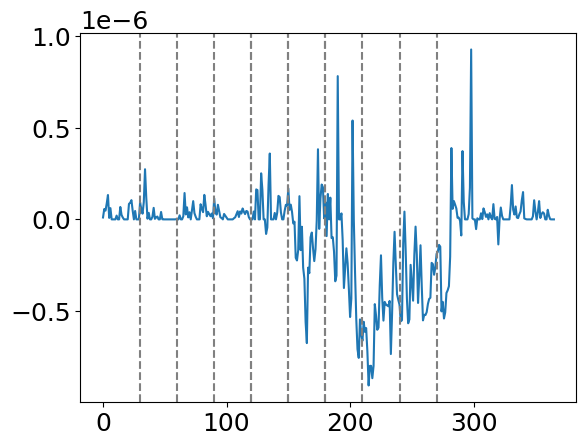

In [37]:
plt.plot(mb_daily[-1])
plt.axvline(30, color='grey', ls='--')
plt.axvline(60, color='grey', ls='--')
plt.axvline(90, color='grey', ls='--')
plt.axvline(120, color='grey', ls='--')
plt.axvline(150, color='grey', ls='--')
plt.axvline(180, color='grey', ls='--')
plt.axvline(210, color='grey', ls='--')
plt.axvline(240, color='grey', ls='--')
plt.axvline(270, color='grey', ls='--')
plt.axvline(120, color='grey', ls='--')
plt.axvline(150, color='grey', ls='--')
plt.axvline(180, color='grey', ls='--')

## get the specific MB

In [38]:
spec_mb_daily = mb_mod.get_specific_daily_mb(heights=h, widths=w, year=np.arange(1980, 2020))
# just a quick check:
spec_mb_yearly = mb_mod.get_specific_mb(heights=h, widths=w,
                                         year=np.arange(1980,
                                                        2020))
spec_mb_daily_yearly_sum = []
for mb in spec_mb_daily:
    spec_mb_daily_yearly_sum.append(mb.sum())
np.testing.assert_allclose(spec_mb_daily_yearly_sum,
                           spec_mb_yearly, rtol=0.05)
# daily specific mass balance summed up over the year is equal to the annual specific mass balance

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:2234: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(out)


this is a very stupid way to do this,  but it works:

In [39]:
j = 0
a = 1980
# we don't use hydro years here 
first_date = np.array('1980-01-01', dtype=np.datetime64)
pd_mb = pd.DataFrame(columns=['daily_specific_mb', 'year'])
for mb_d in spec_mb_daily:
    for m in mb_d:
        pd_mb.loc[first_date + j] = m
        pd_mb.loc[first_date + j, 'year'] = a
        j += 1
    a+=1

In [40]:
pd_mb.groupby(pd_mb.index.month).mean()

,daily_specific_mb,year
1,3.099869,1999.500000
2,2.644163,1999.486726
3,3.033226,1999.500000
4,3.648258,1999.500000
5,2.393937,1999.500000
6,-7.505738,1999.500000
7,-18.053747,1999.500000
8,-18.272268,1999.500000
9,-4.790850,1999.500000
10,1.637296,1999.500000


In [41]:
pd_mb.groupby(pd_mb.index.day_of_year).mean()

,daily_specific_mb,year
1,2.623102,1999.5
2,3.524010,1999.5
3,2.731563,1999.5
4,4.962731,1999.5
5,4.061281,1999.5
...,...,...
362,2.653338,1999.5
363,2.990428,1999.5
364,2.308232,1999.5
365,2.230183,1999.5


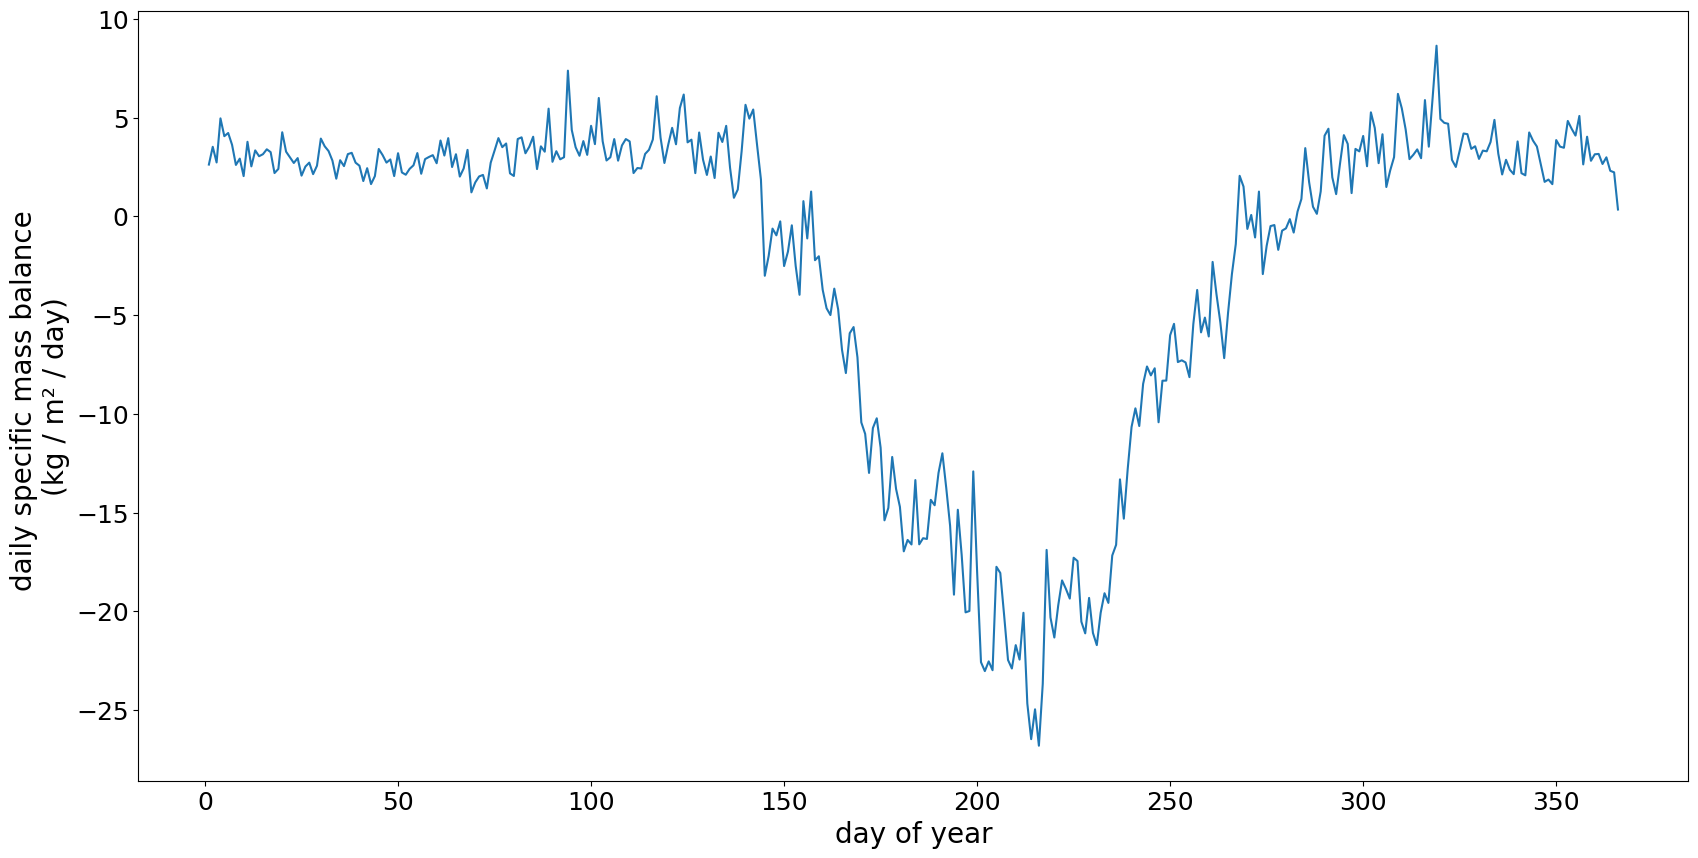

In [42]:
plt.figure(figsize=(20,10))
plt.plot(pd_mb.groupby(pd_mb.index.day_of_year).mean()['daily_specific_mb'])
plt.xlabel('day of year')
plt.ylabel('daily specific mass balance \n(kg / m² / day)');

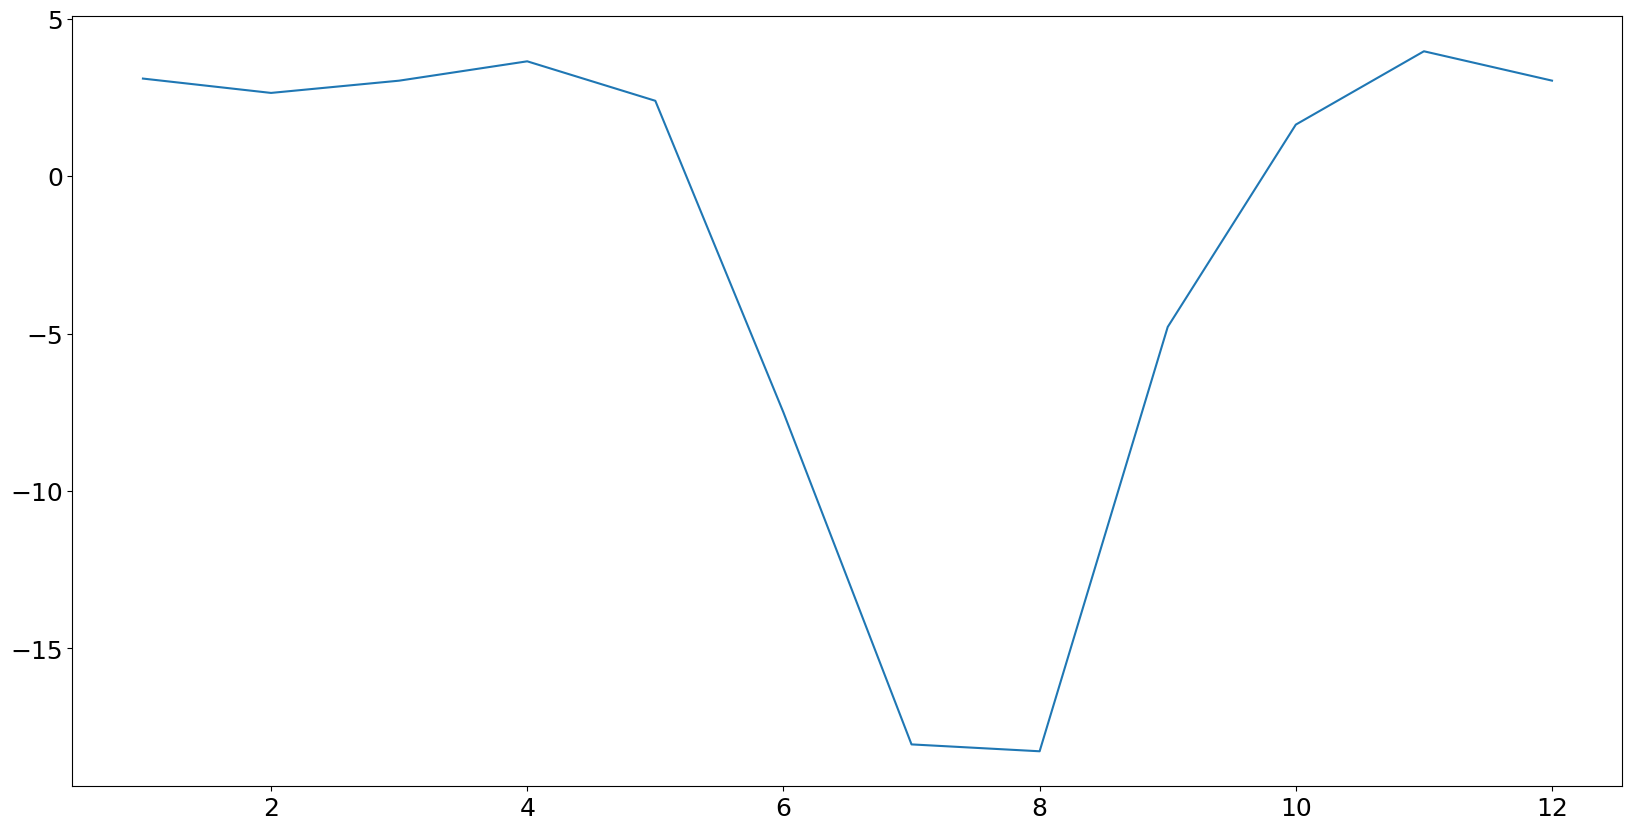

In [43]:
plt.figure(figsize=(20,10))

plt.plot(pd_mb.groupby(pd_mb.index.month).mean()['daily_specific_mb'])